In [1]:
import networkx as nx
from numpy.linalg import matrix_power
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

In [2]:
plt.rcParams["figure.figsize"] = (15, 9)

In [23]:
def isklburnable(g, k, l):
    '''
    input:
    g: graph with networkx form
    k: number of sources
    l: number of rounds
    '''
    ############################################ Step0: get information
    N = nx.number_of_nodes(g)
    g_copy = cp.deepcopy(g)
    ''''''
    ########################################### Step1: get L
    L_list, tellburnfromL = getL(g, N, l, k)
    
    print(tellburnfromL)
    if tellburnfromL == True:
        return np.array(L_list[0]), [x for x in g.nodes()], True
    
    ########################################### Step2: initial
    source = -1*np.ones(k) #burnding sequence
    bestsequence = [[], []] #1st entry: burning sequence; 2nd: number of burned nodes by this bs
    
    R_dynamic = [cp.copy(L_list[0])]
    burned = []
    level_burned = [[]] 
    burned, source, level_burned, R_dynamic = updateR(k, L_list, g, 0, burned, source, level_burned, R_dynamic)
    
    #New check
    if len(burned) == N:
        return source, burned, True 
    '''
    print("2.1 初始化后： ")
    print("source1", source)
    print("R1", R_dynamic)
    print("burned", burned)
    print("level_burned", level_burned)
    print("\n")
    '''
    ########################################### Step3: loop   
    while len(R_dynamic) != 0:
        print("track R", R_dynamic)#TODO:delete
        while len(R_dynamic[k - 1]) != 0:
            
            '''1. check: finish burn k rounds'''
            # 1.1 pick source at end of round
            source[k - 1] = R_dynamic[k - 1][0] # pick 1st 
            R_dynamic[k-1].remove(R_dynamic[k - 1][0]) #remove 1st
            print("track R", R_dynamic)#TODO:delete
            burned.append(source[k-1]) 
            burned = list(set(burned))#TODO: burned change to set
            
            if len(burned) == N:
                return source, burned, True
           
            '''2. burned B for rest rounds'''
            B = cp.copy(burned)# assign for iteration
            for rest_rounds in range(l - k): #l-k
                B = findB(B, g)
                B = list(set(burned))# remove replication
                if len(B) == N:
                    return source, B, True
                
            '''3. fail to burn '''
            burned.remove(source[k-1])
            if len(bestsequence[1]) < len(B):
                print('Best sequence', bestsequence[0], bestsequence[1])
                bestsequence[0] = cp.copy(source)
                bestsequence[1] = cp.copy(B)    
        
        source[k-1] = -1
        #update variables to return 
         
        print("track R", R_dynamic)#TODO:delete      
        #R_dynamic.remove(R_dynamic[k - 1]) #remove the bottom level      
        del R_dynamic[-1]   
        print("track R", R_dynamic)#TODO:delete
        
        level_burned[k - 2].remove(source[k - 2])
        #level_burned.remove(level_burned[k-1]) #this level is a special case: k-1  round decides kth 
        del level_burned[k-1]
        
        #upburned will replace burned
        upburned = []
        for i in level_burned:
            upburned = upburned + i
        
        #TODO: search to delete
        print("底层向上")
        print("source", source, len(upburned))
        print("level_burned", level_burned)
        print("R", R_dynamic)
        
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, k-2, upburned, source, level_burned, R_dynamic) #go back to upper level 0, 1, ..., k-2, k-1 
        
        print("回到底层")
        print("source", source, len(burned))
        print("level_burned", level_burned)
        print("R", R_dynamic)
        if len(burned) == N:
            return source, burned, True  
        #Todo: what if returned R is 0
    
    return bestsequence[0], bestsequence[1], False
    


In [18]:
def getL(g, N, l, k):
    L_list = [[x for x in g.nodes()]]
    tellburnedfromL = False
    num_remove = 0
    
    gl = cp.deepcopy(g) #used for l
    initial = range(N) 
    for i in range(l - 1):
        leaves = updateL(initial, gl)
        initial = cp.deepcopy(leaves)
        L_list.append(initial)
    L_list.reverse()
    
    
    #TODO: fix1 initial empty
    
    while(len(L_list[0]) == 0):
      L_list.remove(L_list[0])
      #the second could only be 0, 1 or 2
      tellburnedfromL = True
      num_remove = num_remove + 1
    if len(L_list[0]) == 1:
      tellburnedfromL = True
    
    print("1得到L")
    print(L_list)
    print("\n")
    
    return L_list, tellburnedfromL

def updateL(input, g):#S1 get all leaves
    temp = [x for x in g.nodes() if g.degree(x)<=1] 
    #TODO:fix 2 <= 1 single node with degree 0
    
  #S2.1 remove leaves from graph
    for i in range(len(temp)): 
      g.remove_node(temp[i])
  #S2.2 return all non-leaves 
    return [x for x in input if x not in temp]
  

In [5]:
def findB(burned, gg):
    '''
        input: 
        a) burned: list of burned nodes
        b) gg: total graph
        output:
        nodes_burned_till_this_round
    '''
    nodes_burned_till_this_round = cp.copy(burned)
    # find all bunred vertice's neignbors
    for this_node in burned:
        nb_of_source = nx.all_neighbors(gg, this_node)
            
        for x in nb_of_source:
            if x not in nodes_burned_till_this_round: # keep unique
                nodes_burned_till_this_round.append(x)
    
    return nodes_burned_till_this_round #返回B set


In [21]:
def updateR(k, L_list, g, num, burned, source, level_burned, R_dynamic):
    # 0 judge and recursion
    '''
    print("开始， 初始值是")
    print("在第几层：", num)
    print("source", source)
    print("R", R_dynamic)
    print("burned", burned)
    print("level_burned", level_burned)
    print("此时R长度是",len(R_dynamic[num]))
    '''
    #TODO: what if it is empty?
    '''0 precheck: walk upwards if the R set this level is empty'''
    if len(R_dynamic[num]) == 0: #this row does not exist
        #print("进入向上走")
        if num == 0:
            #print("向上最终情况")
            #R_dynamic.remove(R_dynamic[num])
            del R_dynamic[-1]
            return burned, source, level_burned, R_dynamic
            #或者直接停/return best
            
        #else:
        # Walk up
        #print("向上的循环")
        del R_dynamic[num]
        del level_burned[num]
        # R_dynamic.remove(R_dynamic[num])
        #level_burned.remove(level_burned[num])
        level_burned[num - 1].remove(source[num - 1])
        
        #upburned will replace burned
        upburned = []
        for i in level_burned:
            upburned = upburned + i
        '''    
        print("向上走")
        print("R", R_dynamic)
        print("burned", upburned)
        
        print("结束")
        print("\n")
        '''  
        print("向上走", num)
        print("source", source, len(burned))
        print("level_burned", level_burned)
        print("R", R_dynamic)
        
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, num - 1, upburned, source, level_burned, R_dynamic)
        return burned, source, level_burned, R_dynamic


    '''1 normal process'''    
    # 1.the process of pick new source after burning
    '''
    source[num] = R_dynamic[num][0]
    R_dynamic[num].remove(R_dynamic[num][0])
    '''
    
    max_degree = -1
    for i in R_dynamic[num]:
        if g.degree[i] > max_degree:
            source[num] = i
            max_degree = g.degree[i]
            
    R_dynamic[num].remove(source[num])
    burned.append(source[num])
    burned = list(set(burned)) # remove
    old_burned = cp.copy(burned)
    level_burned[num].append(source[num])
    '''
    print("更新值是")
    print("1 source", source)
    print("2 R should remove", R_dynamic)
    print("3 burned", burned)
    print("5 level_burned", level_burned)
    '''
    # 2. update R
    # 2.1 get all burned nodes(B) in this round
    B = findB(burned, g)#TODO: copy? # PS: 也可以让findB只返回新burn的vertices
    # 2.2 update level_burn
    level_burned.append([node for node in B if node not in old_burned])#all burned this round - all burned last round
    
    burned = cp.copy(B) #update burn
    '''     
    print("4 更新的burned", burned)
    print("5 更新的level_burned", level_burned)
    '''
    # 2.3 get L/B and update to the total R
    R_next_level = [node for node in L_list[num + 1] if node not in burned] #update R next level
    #print("处理前的R", R_next_level)
    # deal with empty R
    if len(R_next_level) == 0:
        '''
        print("inside empty check")
        print("端点两头",num + 2, len(L_list))
        '''
        # case1: no lower options
        if num + 2 == len(L_list): 
            return burned, source, level_burned, R_dynamic
        
        # case2: walk down
        for inner_num in range(num + 2, len(L_list)): #choose [num + 2, ..., l - 1]
            R_next_level = [node for node in L_list[inner_num] if node not in burned]
            # A. get new set, end find
            if len(R_next_level) != 0:
                break
            '''
            print("num ", inner_num)
            print("R", R_dynamic, R_next_level)
            '''
            # B. reach end and all empty
            if inner_num == len(L_list) - 1:
                R_dynamic.append(R_next_level)#put empty ?
                return burned, source, level_burned, R_dynamic
          
    R_dynamic.append(R_next_level)
    '''
    print("6 R updated", R_dynamic)
    print("for ", num, "th round")
    show2(g, burned)
    '''
    # 3. Walk down: if have not reach the k-1 level， to next level(0, 1, ..., k-2, k-1)
    if num < k - 2: #TODO: deal with new change of L_list (and num < len(L_list) - 2)
        #print("结束向下走\n")
        print("向下走", num)
        print("source", source, len(burned))
        print("level_burned", level_burned)
        print("R", R_dynamic)
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, num + 1, burned, source, level_burned, R_dynamic)
    
    #print("到达updateR最下面的返回")       
    return burned, source, level_burned, R_dynamic

In [8]:
# G: NetworkX graph
# burnt: a list of original labeled nodes that get burnt [3,1,2] in the above example (看上面的上面的图)
# sources: a list of origin labeled sources [3,2]
# labels: a dictionary with key: original labeled node, value: in what round it burnt {2:'1',3:'2'}
def show(G, sources, burnt):
    labels = {}
    valid_source = len(sources)
    for i in range(len(sources)):
        if sources[i] != -1:
            labels[sources[i]] = i + 1
        if sources[i] == -1:
            valid_source = i
            
    print(labels, len(labels))
    
    pos=nx.spring_layout(G)
    ''' '''
    pos_copy = cp.copy(pos)
    nx.draw_networkx(G, pos=pos_copy,arrows=None, with_labels=True)
    plt.show()
    
    nx.draw_networkx(G, pos=pos,arrows=None, with_labels=False)    # plot original graph
    nx.draw_networkx(G, pos=pos,nodelist = burnt,arrows=None, node_color="tab:green",with_labels=False) # represent burnt nd
    
    if (len(labels) != 0) :
        nx.draw_networkx(G, pos=pos,nodelist = sources[:valid_source],arrows=None, node_color="tab:red",with_labels=False) # represnet sources
        description = nx.draw_networkx_labels(G,pos=pos,labels=labels)    # plot sources' 


In [9]:
def drawgraph(g_target, k, l):
    gs, gb, gt = isklburnable(g_target, k, l)
    print("can burned", gt)
    print("burning sequence is", gs)
    show(g_target, gs, gb)    


In [8]:
def drawgraph2(g_target, k, l):
    #g_target list of graphs
    for small_g in g_target:
        gs, gb, gt = isklburnable(small_g, k, l)
        print("can burned", gt)
        print("burning sequence is", gs)
        show(g_target, gs, gb)    

In [25]:
N = 5
k = 5
test_graph = nx.path_graph(26)
test_graph2 = nx.random_tree(11)

1得到L
[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]]


False
向下走 0
source [ 3. -1. -1. -1.] 3
level_burned [[3.0], [2, 4]]
R [[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
向下走 1
source [ 3.  5. -1. -1.] 6
level_burned [[3.0], [2, 4, 5.0], [1, 6]]
R [[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [6, 7, 8, 9, 10, 11, 12, 13, 14], [7, 8, 9, 10, 11, 12, 13, 14, 15]]
track R [[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [6, 7, 8, 9, 10, 11, 12, 13, 14], [8, 9, 10, 11, 12, 13, 14, 15], [9, 10, 11, 12, 13, 14, 15, 16]]
track R [[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [6, 7, 8, 9, 10, 11, 12, 13, 14], [8, 9, 10, 11, 12, 13, 14, 15], [10, 11, 12, 13, 14, 15, 16]]
Best sequence [] []
track R [[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [6, 7, 8, 9, 10, 11, 12, 13, 14], [8, 9, 10, 11, 12, 13, 14, 15], [11, 12, 13, 14, 15, 16]]
track R [[4, 5, 6, 7, 8, 

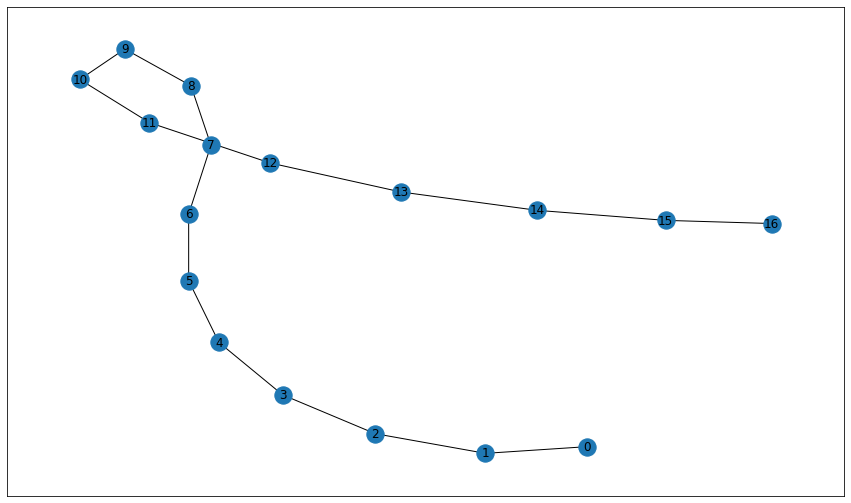

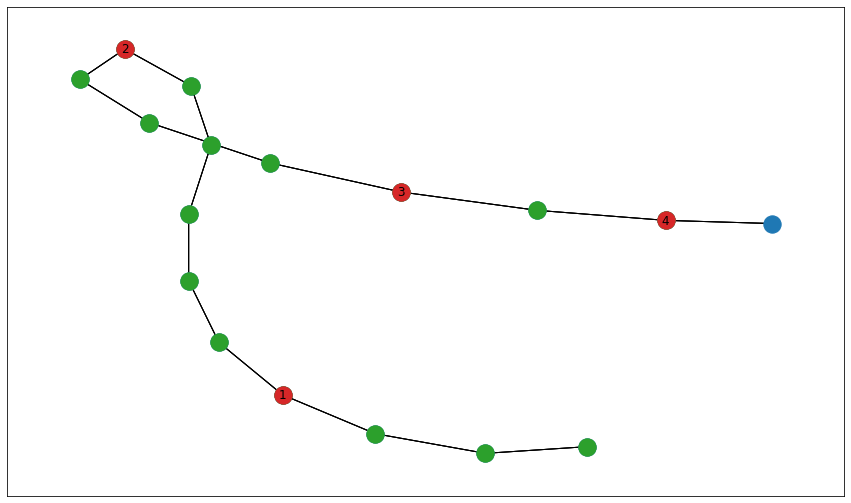

In [26]:
drawgraph(test_graph, k, N)

In [20]:
L =  [0.0, 1, 2.0, 4.0, 5, 9, 10, 12, 13, 15, 17, 21, 22, 23, 25, 28, 29, 31, 32, 36, 37, 38, 39, 43, 45, 47, 51, 53, 54, 55, 56, 62, 63, 11, 20, 40, 14, 52, 48, 57, 7, 35, 44, 8, 49, 50, 41, 16, 34, 59, 58, 33, 19, 61, 3, 46, 18, 60, 42, 30, 26, 6, 27, 24]
L_new = list(set(L))
print(L_new, "\n", len(L_new), len(L))

[0.0, 1, 2.0, 3, 4.0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63] 
 64 64


In [82]:
A = [1, 2, 3]
B = [[1], [2]]
B.remove(B[1])
B
[[0.0], 
 [53, 47, 28, 4.0], 
 [36, 21, 31, 15, 9, 55, 54, 2.0, 13.0], 
 [32, 62, 10, 13, 1, 5, 56, 25, 43, 51, 23, 45, 29, 38, 39, 63, 12, 17, 37, 22], 
 [11, 20, 40, 14, 52, 48, 57, 7, 35, 44, 8, 49, 50, 41, 16, 34, 59, 58, 33, 19, 61, 3, 46, 18, 60, 42, 30, 26, 6, 27, 24]]

[[1]]

In [15]:
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, []]
del a[-1]
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]